#Step 1: Mood Detection (Input Preprocessing)

In [2]:
import os
import numpy as np
import torch
# import evaluate
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    EvalPrediction
)
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score


In [ ]:
# --- 1. Setup ---
# Disable W&B logging as it was not being used in the original notebook
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
!pip install  torch
!pip install -U transformers



In [3]:
# --- 2. Load Dataset and Define Labels ---
# Load the simplified version of the GoEmotions dataset
dataset = load_dataset("go_emotions", "simplified")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [5]:
import pandas as pd

# Convert train split to pandas DataFrame
df = dataset["train"].to_pandas()

# Show first 5 rows
df.sample(7)


,text,labels,id
18545,LETS FUCKING GOOOOO,[2],ee9u7bz
24766,"Oh shit, that makes a lot of sense, thanks for...","[11, 15]",ee0pn9b
38074,I was jumping the same gun but decided to do s...,[17],edyp81o
13401,"Thank god, you're right. At least this idiocy ...",[15],eerx6td
22714,I loved how proud [NAME] looked,[18],eezu5ys
33466,[NAME] is super happy. Nice.,"[0, 17]",edxi109
38364,OK. That is really weird.,[4],ee2z2gl


In [6]:
# Get label information
label_names = dataset["train"].features["labels"].feature.names
num_labels = len(label_names)


In [12]:
label_names

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

In [8]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten all label lists and count
all_labels = [label for row in dataset["train"]["labels"] for label in row]
label_counts = Counter(all_labels)

# Map to label names
label_counts_named = {label_names[k]: v for k, v in label_counts.items()}


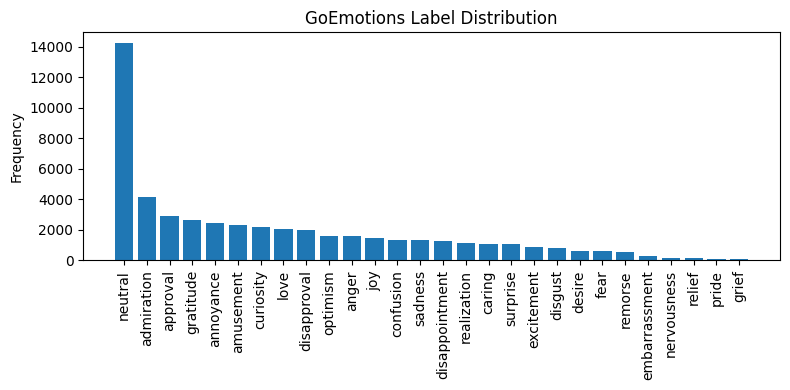

In [9]:
# Sort by count
sorted_counts = dict(sorted(label_counts_named.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(8,4))
plt.bar(sorted_counts.keys(), sorted_counts.values())
plt.xticks(rotation=90)
plt.title("GoEmotions Label Distribution")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [ ]:
# --- 3. Load Tokenizer ---
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# --- 4. Preprocessing Function ---
# Function to tokenize text
def tokenize_data(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Function to create one-hot encoded float labels in a new column
def create_float_labels(examples):
    labels_one_hot = []
    for labels_list in examples["labels"]:
        one_hot_vector = [0.0] * num_labels
        for label_id in labels_list:
            if 0 <= label_id < num_labels:
                one_hot_vector[label_id] = 1.0
        labels_one_hot.append(one_hot_vector)
    # Create a new column for the float labels to avoid type conflicts
    examples["float_labels"] = labels_one_hot
    return examples

In [ ]:
# --- 5. Apply Preprocessing ---
# Step 5.1: Tokenize the text
tokenized_dataset = dataset.map(tokenize_data, batched=True)


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
# Step 5.2: Create the new column with float labels
tokenized_dataset = tokenized_dataset.map(create_float_labels, batched=True)


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
# Step 5.3: Remove old columns, including the original integer 'labels'
tokenized_dataset = tokenized_dataset.remove_columns(["text", "id", "labels"])


In [ ]:
# Step 5.4: Rename the new float column to 'labels' as expected by the Trainer
tokenized_dataset = tokenized_dataset.rename_column("float_labels", "labels")


In [ ]:
# --- 6. Set Format for PyTorch ---
# This converts the lists into torch.Tensors with the correct float dtype for labels
tokenized_dataset.set_format("torch")

In [ ]:
# --- 7. Model Initialization ---
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# --- 8. Metrics Computation ---
def compute_metrics(p: EvalPrediction):
    logits = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    labels = p.label_ids

    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(logits))
    y_pred = (probs.numpy() > 0.5).astype(int)
    y_true = labels.astype(int)

    f1 = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro', multi_class='ovo')
    accuracy = accuracy_score(y_true, y_pred)

    return {'f1_micro': f1, 'roc_auc': roc_auc, 'accuracy': accuracy}


In [ ]:
# Verify the columns after mapping
print("Columns after tokenization (should now include 'labels'):")
if isinstance(tokenized_dataset, DatasetDict):
    for split in tokenized_dataset.keys():
        print(f"  {split}: {tokenized_dataset[split].column_names}")
else:
    print(f"  {tokenized_dataset.column_names}")

Columns after tokenization (should now include 'labels'):
  train: ['input_ids', 'attention_mask', 'labels']
  validation: ['input_ids', 'attention_mask', 'labels']
  test: ['input_ids', 'attention_mask', 'labels']


In [ ]:
# --- 9. Training Arguments ---
# Configure training parameters
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,
    logging_dir='./logs',
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    greater_is_better=True,
    save_total_limit=1,
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# --- 10. Trainer Initialization ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
# --- 11. Start Training ---
# This command will now execute without the runtime error
history = trainer.train()

Epoch,Training Loss,Validation Loss,F1 Micro,Roc Auc,Accuracy
1,0.139600,0.093070,0.518675,0.698525,0.397715
2,0.088300,0.085715,0.551082,0.716964,0.420015
3,0.078400,0.084312,0.573786,0.735600,0.454847
4,0.071700,0.084924,0.572227,0.736338,0.451161
5,0.067200,0.085513,0.581675,0.744986,0.464431


In [ ]:
# --- 12. Evaluate on Test Set ---
test_results = trainer.evaluate(eval_dataset=tokenized_dataset["test"])
print("\nTest Set Evaluation Results:")
print(test_results)


Test Set Evaluation Results:
{'eval_loss': 0.08460130542516708, 'eval_f1_micro': 0.5828361633776962, 'eval_roc_auc': 0.7460536148577933, 'eval_accuracy': 0.4671088999447208, 'eval_runtime': 4.6248, 'eval_samples_per_second': 1173.452, 'eval_steps_per_second': 36.758, 'epoch': 5.0}


In [ ]:
# The directory where you want to save the model files
model_save_path = "./fine-tuned-goemotions-model"

# Save the model and tokenizer to that directory
trainer.save_model(model_save_path)

In [ ]:
import shutil

# The name you want for your final zip file (without the .zip extension)
zip_output_filename = "goemotions_model_archive"

# The directory containing your saved model files
directory_to_zip = model_save_path

# Create the zip file
shutil.make_archive(zip_output_filename, 'zip', directory_to_zip)

print(f"Successfully created zip file: {zip_output_filename}.zip")

Successfully created zip file: goemotions_model_archive.zip


In [ ]:
# For Google Colab users
from google.colab import files

files.download(f"{zip_output_filename}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Inference

In [205]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --- Use the EXACT path you verified in Step 1 ---
model_path = "/content/drive/MyDrive/goemotions_model"
tokenizer_name = "distilbert-base-uncased"

In [206]:
# --- Load Model and Tokenizer ---
print(f"Loading model from: {model_path}")
model = AutoModelForSequenceClassification.from_pretrained(model_path)
print(f"Loading tokenizer from: {tokenizer_name}")
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)


Loading model from: /content/drive/MyDrive/goemotions_model
Loading tokenizer from: distilbert-base-uncased


In [207]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() # Set the model to evaluation mode
print("✅ Model and tokenizer loaded successfully.")


✅ Model and tokenizer loaded successfully.


In [208]:
# --- 2. Inference Function ---
def predict_emotions(text_list):
    """
    Takes a list of sentences and returns their predicted emotions.
    """
    inputs = tokenizer(
        text_list,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        logits = model(**inputs).logits

    probabilities = torch.sigmoid(logits)
    threshold = 0.5
    predictions = (probabilities > threshold).int().cpu().numpy()

    results = []
    for i, sentence in enumerate(text_list):
        predicted_indices = predictions[i].nonzero()[0]

        if len(predicted_indices) > 0:
            predicted_labels = [model.config.id2label[idx] for idx in predicted_indices]
        else:
            predicted_labels = ["neutral"]

        results.append({
            "sentence": sentence,
            "predicted_emotions": predicted_labels
        })
    return results




In [224]:
# --- 3. Run Prediction ---
sentences_to_predict = [
    "I'm so excited for the concert this weekend!",
    "He was late again. I am really annoyed.",
    "I am missing a mug of coffee in this cloudy weather",
    "I am feeling so calm, happy,  relaxed and cheerful today",
    "I am feeling so down and depressed in a while.",
    "Finally, I am in love with the most beautiful girl I have ever met"
]

predictions = predict_emotions(sentences_to_predict)

In [225]:
# --- Print Results ---
print("\n--- Inference Results ---")
for result in predictions:
    print(f"\nSentence: '{result['sentence']}'")
    print(f"  Predicted Emotions: {', '.join(result['predicted_emotions'])}")


--- Inference Results ---

Sentence: 'I'm so excited for the concert this weekend!'
  Predicted Emotions: excitement

Sentence: 'He was late again. I am really annoyed.'
  Predicted Emotions: annoyance

Sentence: 'I am missing a mug of coffee in this cloudy weather'
  Predicted Emotions: neutral

Sentence: 'I am feeling so calm, happy,  relaxed and cheerful today'
  Predicted Emotions: joy

Sentence: 'I am feeling so down and depressed in a while.'
  Predicted Emotions: sadness

Sentence: 'Finally, I am in love with the most beautiful girl I have ever met'
  Predicted Emotions: love
